# Análisis de sentimientos usando RNN

En la siguiente sección se estudiarán los resultados de utilizar redes neuronales recurrentes (RNN) en la predicción del sentimiento, positivo o negativo, de reseñas generadas por distintos usuarios, por lo que se utilizara el conjunto de datos IMDB dataset el cual consiste en un conjunto de datos etiquetado compuesto por 50000 reseñas de películas en IMDB, el sentimiento generado se representa de forma binaria, donde el valor 1 corresponde a que el usuario escribió una crítica positiva de la película, y el valor 0 indica que el usuario realizo una crítica negativa. 

In [394]:
import numpy as np

from collections import defaultdict
from math        import log10
from matplotlib	 import pyplot as plt
from IPython.display import HTML, display
from scipy.stats import skew
from skimage import io
import matplotlib.image as mpimg

from keras.datasets          import imdb
from keras.layers            import Dense
from keras.layers            import Dropout
from keras.layers            import LSTM
from keras.models            import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing     import sequence

## a) Carga del conjunto de datos

In [361]:
np.random.seed(3)
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=15)

Los conjuntos de entrenamiento y pruebas se componen de 25000 reseñas etiquetadas cada uno, además el conjunto de entrenamiento no incluye ninguna película presente en el conjunto de pruebas y cada película seleccionada pose un máximo de 30 reseñas. Los elementos de los conjuntos $X_{train}$ y $X_{test}$ corresponden a vectores, donde los elementos de cada vector representan las palabras de las reseñas.

In [328]:
def display_as_table(data, header=None, caption=None, multi_dim=False):
    out_str = '<table>'
    if (caption):
        out_str += '<caption>' + str(caption) + '</caption>'
    if (header):
        out_str += '<tr><th>{}</th></tr>'.format('</th><th>'.join(str(_) for _ in header))
    if (multi_dim):
        out_str += '<tr>{}</tr>'.format('</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data))
    else:
        out_str += '<tr><td>{}</td></tr>'.format('</td><td>'.join(str(_) for _ in data))
        
    out_str += '</table>'
    display(HTML(out_str))
    
def do_regL(X, Y):
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    sum_a = 0
    sum_b = 0
    for i in range(len(X)):
        aux_x = X[i] - mean_x
        aux_y = Y[i] - mean_y
        sum_a += aux_x * aux_y
        sum_b += aux_x**2
    b1 = sum_a/sum_b
    b0 = mean_y - mean_x * b1
    return (b0, b1)

## b) Distribución del conjunto de datos
### Distribución del largo de las reseñas

Review length: 


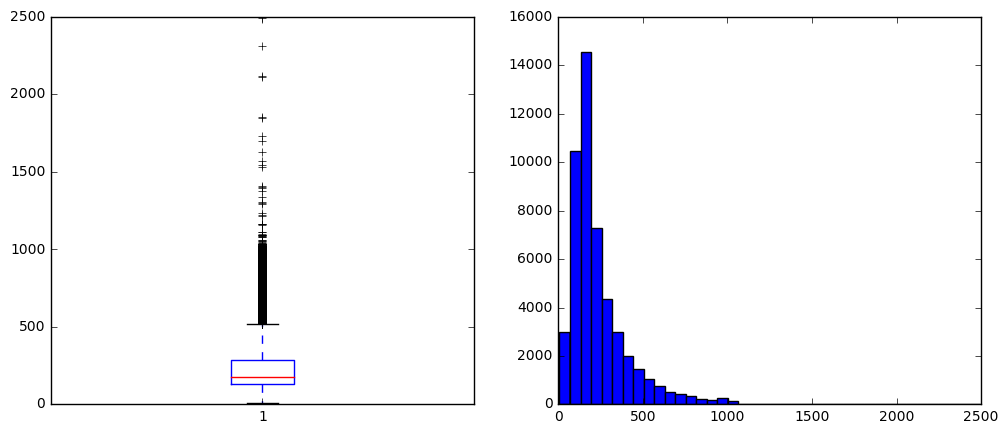

In [362]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

print("Review length: ")
result = list(map(len, X))
f, axarr = plt.subplots(1, 2,figsize=(12,5))
axarr[0].boxplot(result)
axarr[1].hist(result, 40)
plt.show()

In [363]:
p25 = np.percentile(result, 25)
p50 = np.percentile(result, 50)
p75 = np.percentile(result, 75)
rci = p75 - p25
li  = max(p25 - rci*1.5, 0)
ls  = p75 + rci*1.5
amn_out = len([_ for _ in result if _ > ls])
per_out = str(100*amn_out/50000) + '%'

head_list = ['Limite inf', 'Percentil 25', 'Percentil 50', 'Percentil 75', 'Limite sup', 'Cant outliers', '% outliers', 'Media', u'Desviación estánda', u'Coef simetría']
data_list = [li, p25, p50, p75, ls, amn_out, per_out, np.round(np.mean(result),3), np.round(np.std(result),3), np.round(skew(result),3)]
cap = u'Información sobre el largo de las reseñas'
display_as_table(data_list, header=head_list, caption=cap)

Limite inf,Percentil 25,Percentil 50,Percentil 75,Limite sup,Cant outliers,% outliers,Media,Desviación estánda,Coef simetría
0,129.0,176.0,285.0,519.0,3689,7.378%,234.759,172.911,2.16


De la información presentada sobre el comportamiento del largo de las reseñas pertenecientes al conjunto de datos se aprecia que un 50% de las reseñas posen un largo entre 129 a 285 palabras, no existen valores atípicos de largo reducido, pero existen un total de 3689 valores atípicos de gran largo, en concreto las reseñas con un largo superior a 519 palabras corresponden a valores atípicos, lo cual corresponde a un 7.378% del conjunto de datos, además el coeficiente de simetría del conjunto de datos es igual a 2.16, lo que indica que la distribución de los datos pose una cola derecha pesada, es decir el largo de las reseñas es más frecuente en valores bajos. Finalmente la media es igual a 234.759 y la desviación estándar 172.911.

### Frecuencia de las palabras

In [364]:
d = defaultdict(int)
for review in X:
    for word in review:
        d[word] += 1

word_frequency = list(d.values())
word_frequency.sort(reverse=True)
rank = range(1, len(word_frequency)+1)
log_word_frequency = list(map(log10, word_frequency))
log_rank = list(map(log10, rank))

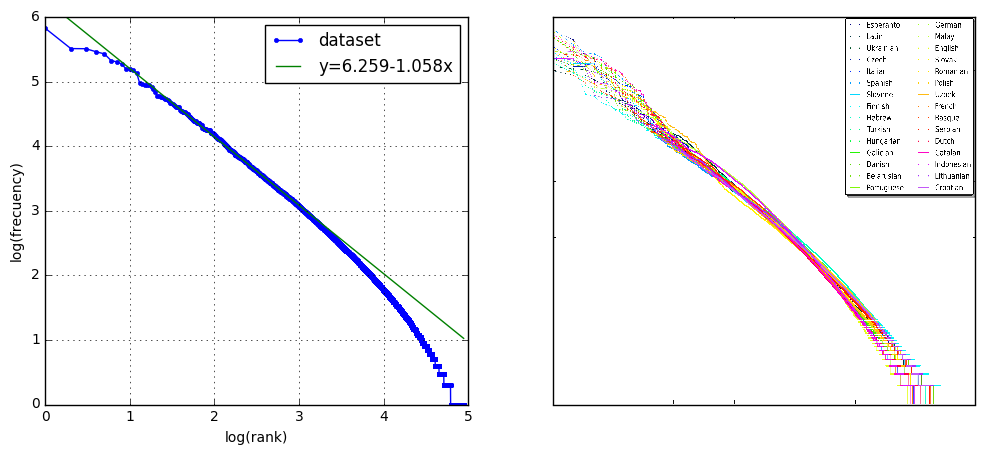

In [365]:
f, axarr = plt.subplots(1, 2,figsize=(12,5))

c, m = do_regL(log_rank[10:500], log_word_frequency[10:500])
axarr[0].plot(log_rank, log_word_frequency, marker=".", label='dataset')
axarr[0].plot(log_rank, [c+m*i for i in log_rank], label='y='+str(np.round(c,3))+str(np.round(m,3))+'x')
axarr[0].set_xlabel('log(rank)')
axarr[0].set_ylabel('log(frecuency)')
axarr[0].axis((0,5,0,6))
axarr[0].legend(loc='upper right')
axarr[0].grid(True)

image = mpimg.imread('gra.png')
axarr[1].imshow(image, interpolation='nearest', aspect='auto')
axarr[1].axes.get_yaxis().set_visible(False)
axarr[1].axes.get_xaxis().set_visible(False)
axarr[1].autoscale(False)

plt.show()

Del grafico de la frecuencia de las palabras utilizadas en las reseñas se aprecia la presencia de la ley de Zipf, la ley de Zipf indica que la frecuencia de aparición de distintas palabras sigue una distribución que se puede aproximar por $P_n \sim n^{-a}$, lo cual se aprecia en el primer gráfico, ya que al graficar el logaritmo de la frecuencia de aparición de las palabras en función del logaritmo del ranking de las palabras se obtiene una recta de pendiente negativa indicando la presencia de la ley de Zipf, en específico se cumple:
$$ y = c \cdot n^{-a} $$
$$ log(y) = log(c \cdot n^{-a}) $$
$$ log(y) = log(c) + log(n^{-a}) $$
$$ log(y) = log(c) + -a \cdot log(n) $$

<p>Para el conjunto de datos se puede aproximar los valores de $a \approx 1.058$ y $log(c) \approx 6.259$. Además, se compara el grafico generado con el resultante de graficar la frecuencia de aparición de las palabras usadas en la página web Wikipedia en distintos idiomas, donde al comparar los dos resultados se aprecia que las frecuencias de aparición de las palabras en el conjunto de datos poseen el comportamiento esperado. Finalmente se aprecia que para palabras poco frecuentes se obtienen frecuencias iguales provocando que la gráfica generada sea similar a una escalera. </p>


In [368]:
dp = defaultdict(int)
dn = defaultdict(int)
for i in range(len(X)):
    for word in X[i]:
        if y[i]:
            dp[word] += 1
        else:
            dn[word] += 1

p_word_frequency = list(dp.values());n_word_frequency = list(dn.values())
p_word_frequency.sort(reverse=True);n_word_frequency.sort(reverse=True)
p_rank = range(1, len(p_word_frequency)+1);n_rank = range(1, len(n_word_frequency)+1)
p_log_word_frequency = list(map(log10, p_word_frequency));n_log_word_frequency = list(map(log10, n_word_frequency))
p_log_rank = list(map(log10, p_rank));n_log_rank = list(map(log10, n_rank))

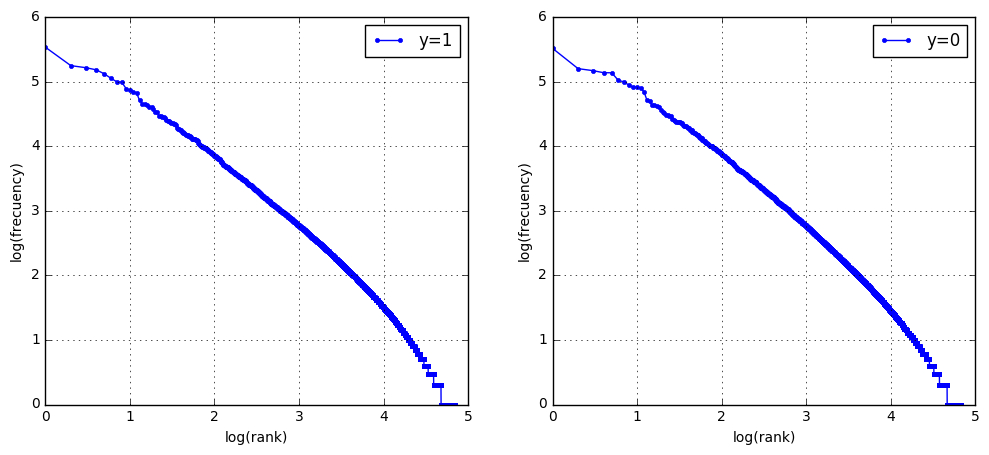

In [372]:
f, axarr = plt.subplots(1, 2,figsize=(12,5))

axarr[0].plot(p_log_rank, p_log_word_frequency, marker=".", label='y=1')
axarr[0].set_xlabel('log(rank)')
axarr[0].set_ylabel('log(frecuency)')
axarr[0].axis((0,5,0,6))
axarr[0].legend(loc='upper right')
axarr[0].grid(True)

axarr[1].plot(n_log_rank, n_log_word_frequency, marker=".", label='y=0')
axarr[1].set_xlabel('log(rank)')
axarr[1].set_ylabel('log(frecuency)')
axarr[1].axis((0,5,0,6))
axarr[1].legend(loc='upper right')
axarr[1].grid(True)

plt.show()

Al separar las reseñas de acuerdo a si son positivas o negativas se aprecian los mismos resultados ya comentados con anterioridad, es decir que las frecuencias de aparición de las palabras siguen la ley de Zipf.

## c) Reducción de la cantidad de palabras y largo de las reseñas del conjunto de datos.

In [392]:
top_words = 3000
review_size = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=review_size)
X_test = sequence.pad_sequences(X_test, maxlen=review_size)

Se reduce la cantidad de palabras presentes en el conjunto de datos a las 3000 palabras más relevantes, es decir las de mayor frecuencia, además de normalizan los largos de las reseñas a 500 palabras, para logras que todas las reseñas posean el mismo largo, las reseñas de largo mayor a 500 se cortan y las reseñas de largo inferior a 500 se rellenan con ceros hasta completar el largo deseado, lo anterior se realizara para poder lograr que todos los comentarios posean el mismo largo, además se utiliza el 0 ya que este no pertenece al conjunto de las palabras utilizadas en las reseñas y se espera que la red interprete este valor como uno que no aporta información al momento de realizar la clasificación. 

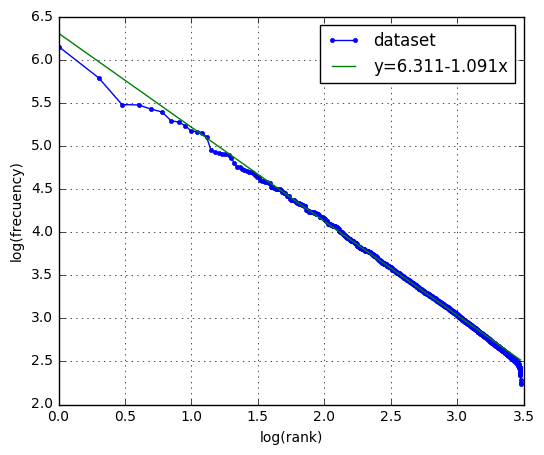

In [389]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

d = defaultdict(int)
for review in X:
    for word in review:
        if word:
            d[word] += 1

word_frequency = list(d.values())
word_frequency.sort(reverse=True)
rank = range(1, len(word_frequency)+1)
log_word_frequency = list(map(log10, word_frequency))
log_rank = list(map(log10, rank))

f, axarr = plt.subplots(1, 1,figsize=(6,5))
c, m = do_regL(log_rank[10:1500], log_word_frequency[10:1500])
axarr.plot(log_rank, log_word_frequency, marker=".", label='dataset')
axarr.plot(log_rank, [c+m*i for i in log_rank], label='y='+str(np.round(c,3))+str(np.round(m,3))+'x')
axarr.set_xlabel('log(rank)')
axarr.set_ylabel('log(frecuency)')
axarr.legend(loc='upper right')
axarr.grid(True)
plt.show()

De la gráfica anterior se aprecia que el conjunto de datos reducido mantiene la ley de Zipf, además la selección de las palabras más frecuentes elimino las palabras de casi nula frecuencia, lo cual puede ayudar a disminuir la cantidad de ruido presente en el conjunto de datos.  

## d) Entrenamiento de una red LSTM

In [7]:
def do_model(input_dim, output_dim, input_length_):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length=input_length_))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
embedding_vector_length = 32
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 149,301.0
Trainable params: 149,301
Non-trainable params: 0.0
_________________________________________________________________


Se crea una red LSTM para evaluar su rendimiento en la tarea de clasificación del conjunto de datos, utilizando la versión ya reducida de este, la primera capa de la red trasforma los índices de las palabras en vectores densos de tamaño fijo, la segunda capa corresponde a la capa de LSTM con 100 neuronas ocultas y finalmente la capa de decisión que utiliza la función de activación sigmoid. El modelo se compone por un total de 149301 parámetros. 

In [9]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 714s - loss: 0.5196 - acc: 0.7336 - val_loss: 0.4462 - val_acc: 0.8049
Epoch 2/3
25000/25000 [==============================] - 685s - loss: 0.4008 - acc: 0.8269 - val_loss: 0.5026 - val_acc: 0.7528
Epoch 3/3
25000/25000 [==============================] - 666s - loss: 0.3246 - acc: 0.8642 - val_loss: 0.3124 - val_acc: 0.8721


Al realizar 3 iteraciones de entrenamiento en la red, se obtiene una precisión sobre el conjunto de pruebas igual a 87,21% y un valor para la función de perdida igual a 0,31, estos valores son buenos dada la poca cantidad de iteraciones realizadas en el modelo.

## e) Variación de la dimensionalidad del embedding inicial
Utilizando el mismo modelo ya entrenado, se procede a cambiar el tamaño de la primera capa de embedding para determinar como el tamaño de esta afecta el rendimiento de la red.

In [10]:
embedding_vector_length = 16
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           48000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 94,901.0
Trainable params: 94,901
Non-trainable params: 0.0
_________________________________________________________________


Primero se crea un modelo con una capa de embedding de dimensionalidad igual a la mitad del modelo original, es decir 16. El nuevo modelo generado pose un total de 94901, lo cual es una cantidad menor de parámetros en comparación al modelo original.

In [11]:
hist16 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores16 = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 676s - loss: 0.4921 - acc: 0.7576 - val_loss: 0.3807 - val_acc: 0.8335
Epoch 2/3
25000/25000 [==============================] - 603s - loss: 0.3488 - acc: 0.8542 - val_loss: 0.3731 - val_acc: 0.8439
Epoch 3/3
25000/25000 [==============================] - 598s - loss: 0.3802 - acc: 0.8370 - val_loss: 0.3754 - val_acc: 0.8422


Al entrenar el modelo con tamaño del embedding igual a 16, se obtuvo una precisión sobre el conjunto de pruebas igual a 84,21% y un valor para la función de perdida igual a 0.38, los valores obtenidos son peores que el primer modelo entrenado.

In [12]:
embedding_vector_length = 64
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 64)           192000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 258,101.0
Trainable params: 258,101
Non-trainable params: 0.0
_________________________________________________________________


Como segunda variación a la dimensionalidad del embedding se utiliza el doble del modelo original, es decir 64. El nuevo modelo generado pose un total de 258101 parámetros, un aumento en comparación al modelo original. 

In [13]:
hist64 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores64 = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 674s - loss: 0.4388 - acc: 0.7897 - val_loss: 0.3209 - val_acc: 0.8695
Epoch 2/3
25000/25000 [==============================] - 670s - loss: 0.3175 - acc: 0.8685 - val_loss: 0.3128 - val_acc: 0.8688
Epoch 3/3
25000/25000 [==============================] - 669s - loss: 0.3081 - acc: 0.8696 - val_loss: 0.3429 - val_acc: 0.8585


Después de entrenar la segunda propuesta de variación de la dimensionalidad del embedding, el valor de precisión sobre el conjunto de pruebas es igual a un 85,85%, y el valor de la función de perdida es igual a 0.34, esta variación tampoco fue capaz de mejorar los resultados del modelo original.

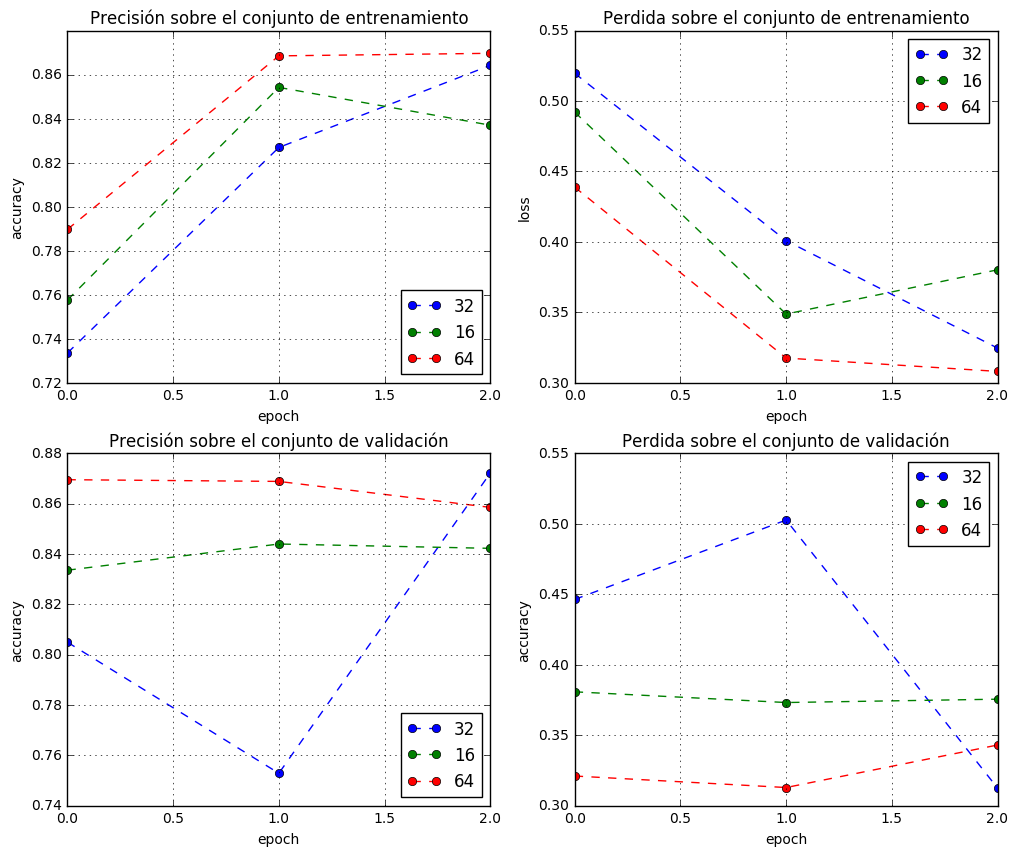

In [423]:
f, axarr = plt.subplots(2, 2,figsize=(12,10))
axarr[0, 0].plot(hist.history['acc'], label='32', marker='o', linestyle='--')
axarr[0, 0].plot(hist16.history['acc'], label='16', marker='o', linestyle='--')
axarr[0, 0].plot(hist64.history['acc'], label='64', marker='o', linestyle='--')
axarr[0, 0].legend(loc='lower right')
axarr[0, 0].set_xlabel('epoch')
axarr[0, 0].set_ylabel('accuracy')
axarr[0, 0].set_title(u'Precisión sobre el conjunto de entrenamiento')
axarr[0, 0].grid(True)

axarr[0, 1].plot(hist.history['loss'], label='32', marker='o', linestyle='--')
axarr[0, 1].plot(hist16.history['loss'], label='16', marker='o', linestyle='--')
axarr[0, 1].plot(hist64.history['loss'], label='64', marker='o', linestyle='--')
axarr[0, 1].legend(loc='upper right')
axarr[0, 1].set_xlabel('epoch')
axarr[0, 1].set_ylabel('loss')
axarr[0, 1].set_title(u'Perdida sobre el conjunto de entrenamiento')
axarr[0, 1].grid(True)

axarr[1, 0].plot(hist.history['val_acc'], label='32', marker='o', linestyle='--')
axarr[1, 0].plot(hist16.history['val_acc'], label='16', marker='o', linestyle='--')
axarr[1, 0].plot(hist64.history['val_acc'], label='64', marker='o', linestyle='--')
axarr[1, 0].legend(loc='lower right')
axarr[1, 0].set_xlabel('epoch')
axarr[1, 0].set_ylabel('accuracy')
axarr[1, 0].set_title(u'Precisión sobre el conjunto de validación')
axarr[1, 0].grid(True)

axarr[1, 1].plot(hist.history['val_loss'], label='32', marker='o', linestyle='--')
axarr[1, 1].plot(hist16.history['val_loss'], label='16', marker='o', linestyle='--')
axarr[1, 1].plot(hist64.history['val_loss'], label='64', marker='o', linestyle='--')
axarr[1, 1].legend(loc='upper right')
axarr[1, 1].set_xlabel('epoch')
axarr[1, 1].set_ylabel('accuracy')
axarr[1, 1].set_title(u'Perdida sobre el conjunto de validación')
axarr[1, 1].grid(True)

plt.show()

Al comparar los resultados obtenidos de las dos variaciones planteadas con el modelo original se aprecia que durante el entrenamiento el embedding de dimensionalidad 32 en las primeras dos iteraciones pose peor precisión que las otras dos propuestas, además se aprecia que el embedding con dimensionalidad 64 no sufre un cambio significante en el valor de la precisión sobre el conjunto de entrenamiento lo cual puede implicar una convergencia prematura por parte de este modelo, y del embedding con dimensionalidad 16 se aprecia que empeora su rendimiento sobre el conjunto de entrenamiento lo cual puede indicar que no es capaz de aprender toda la información del conjunto, lo cual pudo ser provocado por la reducción de parámetros que sufrió esta propuesta.

Al comparar los resultados del conjunto de validación (el mismo que el de pruebas) se observa un empeoramiento del rendimiento del modelo con embedding 32, pero para la tercera iteración el modelo supera el rendimiento de las otras dos propuestas, el comportamiento anterior puede deberse a que el modelo original realizo una exploración del espacio de búsqueda en zonas tentativas y durante la tercera iteración se dedicó a explotar el espacio de búsqueda para mejorar el rendimiento del estado actual, este comportamiento no se observa en las otras dos propuestas, lo cual puede indicar que estas se mantuvieron en la misma zona del espacio de búsqueda o no realizaron una gran exploración, lo cual puede estar relacionado a una convergencia prematura. 


## f) Modificación en la cantidad de palabras significativas
En esta sección se estudia la influencia de la cantidad de palabras más frecuentes que se utilizan para entrenar el modelo.

In [347]:
top_words = 1000
review_size = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=review_size)
X_test = sequence.pad_sequences(X_test, maxlen=review_size)

embedding_vector_length = 32
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 85,301.0
Trainable params: 85,301
Non-trainable params: 0.0
_________________________________________________________________


La primera propuesta consiste en utilizar solo las 1000 palabras más frecuentes, se utiliza la misma estructura del modelo original, la red resultante pose un total de 85301.

In [351]:
hist_top1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores_top1 = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 623s - loss: 0.4858 - acc: 0.7584 - val_loss: 0.3825 - val_acc: 0.8340
Epoch 2/3
25000/25000 [==============================] - 626s - loss: 0.4395 - acc: 0.7928 - val_loss: 0.3591 - val_acc: 0.8444
Epoch 3/3
25000/25000 [==============================] - 620s - loss: 0.3604 - acc: 0.8478 - val_loss: 0.3871 - val_acc: 0.8303


Al entrenar el modelo con las 1000 palabras más significantes se obtiene una precisión del 83.03% sobre el conjunto de pruebas y un valor para la función de pérfida igual a 0.87.

In [352]:
top_words = 2000
review_size = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=review_size)
X_test = sequence.pad_sequences(X_test, maxlen=review_size)

embedding_vector_length = 32
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           64000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 117,301.0
Trainable params: 117,301
Non-trainable params: 0.0
_________________________________________________________________


La siguiente propuesta consiste en usar las 2000 palabras más frecuentes del conjunto de datos, utilizando la misma estructura ya planteada, se obtiene un modelo con un total de 117301 parámetros.

In [353]:
hist_top2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores_top2 = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 748s - loss: 0.5265 - acc: 0.7288 - val_loss: 0.3545 - val_acc: 0.8475
Epoch 2/3
25000/25000 [==============================] - 756s - loss: 0.3281 - acc: 0.8647 - val_loss: 0.3238 - val_acc: 0.8634
Epoch 3/3
25000/25000 [==============================] - 779s - loss: 0.3323 - acc: 0.8646 - val_loss: 0.3613 - val_acc: 0.8426


Al entrenar la segunda propuesta de cantidad de palabras significativas se obtiene una precisión sobre el conjunto de pruebas igual a un 84.26% y un valor para la función de perdida igual a 0.36.

In [390]:
top_words = 4000
review_size = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=review_size)
X_test = sequence.pad_sequences(X_test, maxlen=review_size)

embedding_vector_length = 32
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           128000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 181,301.0
Trainable params: 181,301
Non-trainable params: 0.0
_________________________________________________________________


La última variación para la cantidad de palabras consiste en utilizar las 4000 palabras más frecuentes, el modelo resultante posee un total de 181301 parámetros.  

In [391]:
hist_top4 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores_top4 = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 718s - loss: 0.4732 - acc: 0.7606 - val_loss: 0.3556 - val_acc: 0.8483
Epoch 2/3
25000/25000 [==============================] - 710s - loss: 0.3275 - acc: 0.8666 - val_loss: 0.4445 - val_acc: 0.7904
Epoch 3/3
25000/25000 [==============================] - 780s - loss: 0.3130 - acc: 0.8729 - val_loss: 0.3410 - val_acc: 0.8592


Al realizar el entrenamiento del modelo con las 4000 palabras más significativas,  se obtuvo una precisión sobre el conjunto de pruebas igual a 85.92% y un valor para la función de perdida igual a 0.34.

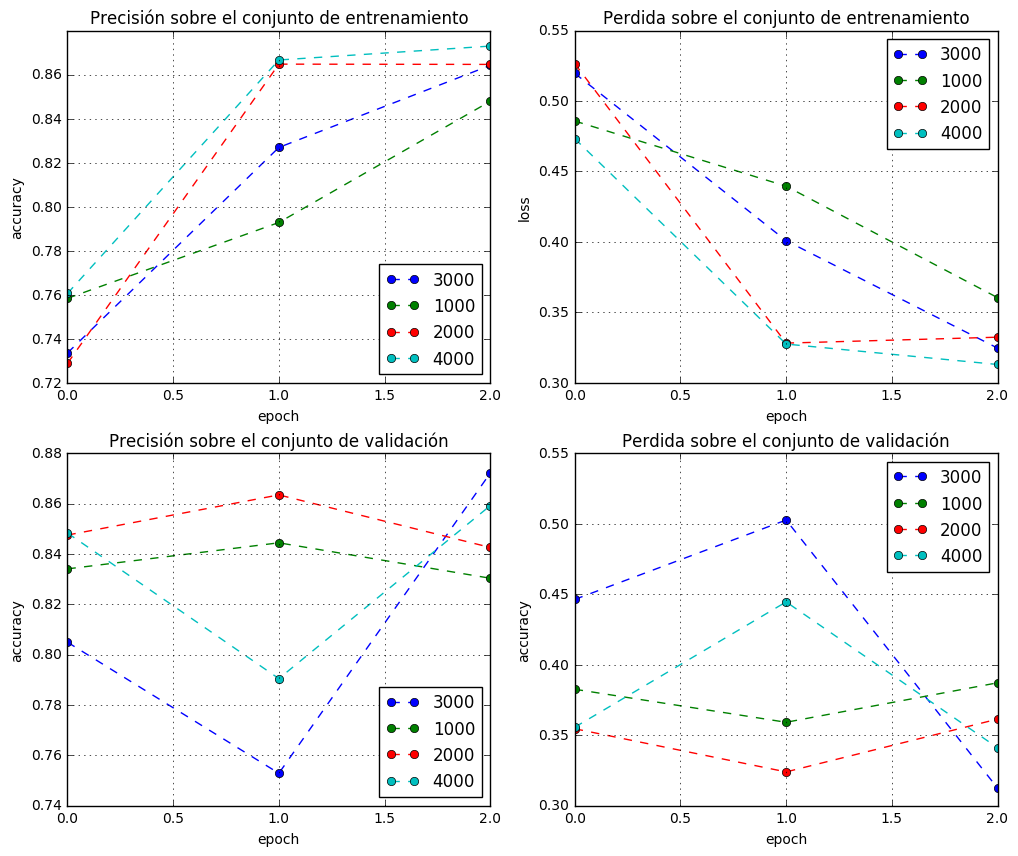

In [428]:
f, axarr = plt.subplots(2, 2,figsize=(12,10))
axarr[0, 0].plot(hist.history['acc'], label='3000', marker='o', linestyle='--')
axarr[0, 0].plot(hist_top1.history['acc'], label='1000', marker='o', linestyle='--')
axarr[0, 0].plot(hist_top2.history['acc'], label='2000', marker='o', linestyle='--')
axarr[0, 0].plot(hist_top4.history['acc'], label='4000', marker='o', linestyle='--')
axarr[0, 0].legend(loc='lower right')
axarr[0, 0].set_xlabel('epoch')
axarr[0, 0].set_ylabel('accuracy')
axarr[0, 0].set_title(u'Precisión sobre el conjunto de entrenamiento')
axarr[0, 0].grid(True)

axarr[0, 1].plot(hist.history['loss'], label='3000', marker='o', linestyle='--')
axarr[0, 1].plot(hist_top1.history['loss'], label='1000', marker='o', linestyle='--')
axarr[0, 1].plot(hist_top2.history['loss'], label='2000', marker='o', linestyle='--')
axarr[0, 1].plot(hist_top4.history['loss'], label='4000', marker='o', linestyle='--')
axarr[0, 1].legend(loc='upper right')
axarr[0, 1].set_xlabel('epoch')
axarr[0, 1].set_ylabel('loss')
axarr[0, 1].set_title(u'Perdida sobre el conjunto de entrenamiento')
axarr[0, 1].grid(True)

axarr[1, 0].plot(hist.history['val_acc'], label='3000', marker='o', linestyle='--')
axarr[1, 0].plot(hist_top1.history['val_acc'], label='1000', marker='o', linestyle='--')
axarr[1, 0].plot(hist_top2.history['val_acc'], label='2000', marker='o', linestyle='--')
axarr[1, 0].plot(hist_top4.history['val_acc'], label='4000', marker='o', linestyle='--')
axarr[1, 0].legend(loc='lower right')
axarr[1, 0].set_xlabel('epoch')
axarr[1, 0].set_ylabel('accuracy')
axarr[1, 0].set_title(u'Precisión sobre el conjunto de validación')
axarr[1, 0].grid(True)

axarr[1, 1].plot(hist.history['val_loss'], label='3000', marker='o', linestyle='--')
axarr[1, 1].plot(hist_top1.history['val_loss'], label='1000', marker='o', linestyle='--')
axarr[1, 1].plot(hist_top2.history['val_loss'], label='2000', marker='o', linestyle='--')
axarr[1, 1].plot(hist_top4.history['val_loss'], label='4000', marker='o', linestyle='--')
axarr[1, 1].legend(loc='upper right')
axarr[1, 1].set_xlabel('epoch')
axarr[1, 1].set_ylabel('accuracy')
axarr[1, 1].set_title(u'Perdida sobre el conjunto de validación')
axarr[1, 1].grid(True)

plt.show()

Al comparar los resultado es posible apreciar que durante el entrenamiento, los modelos entrenados con 2000 y 4000 palabras convergen rápidamente, lo cual puede implicar la presencia de convergencia prematura, provocando que no se explore correctamente el espacio de búsqueda, en cambio las redes con 1000 y 3000 convergen de manera constante, lo cual puede indicar una mejor exploración del espacio de búsqueda, pero el modelo entrenado con 1000 palabras posiblemente no pueda aprender mucha información del conjunto de datos y por eso presenta una precisión en el conjunto de entrenamiento menor al resto. 

De los resultados obtenidos de la validación se aprecia que  la red entrenada con las 3000 palabras más significantes pose mejor rendimiento, y se observa que las redes entrenadas con 3000 y 4000 palabras empeoran su rendimiento en la segunda iteración, y mejoran considerablemente la clasificación en el conjunto de pruebas en la tercera iteración, lo cual puede deberse a la exploración del espacio de búsqueda, pero a pesar de explorar bien el espacio de búsqueda la red con 4000 palabras no puede evitar la convergencia prematura. 

## g) Entrenamiento con Dropout
En esta sección se evalúa el impacto que provoca utilizar capas de dropout en el modelo ya estudiado.

In [395]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=500))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 149,301.0
Trainable params: 149,301.0
Non-trainable params: 0.0
_________________________________________________________________


Utilizando como base el modelo ya estudiado, se añade una capa de dropout después de la capa de embedding y otra después de la capa LSTM, las dos capas de dropout posen un valor de 0.2, el modelo resultante pose un total de 149301 parámetros, lo que indica que las capas de dropout no disminuyeron la cantidad de parámetros a entrenar.

In [397]:
hist_drop = model.fit(X_train, y_train, epochs=3, batch_size=64)
scores_drop = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/3
25000/25000 [==============================] - 520s - loss: 0.4923 - acc: 0.7528   
Epoch 2/3
25000/25000 [==============================] - 525s - loss: 0.3352 - acc: 0.8613   
Epoch 3/3
25000/25000 [==============================] - 562s - loss: 0.2819 - acc: 0.8870   


In [427]:
scores_drop

[0.32250434616565704, 0.86268]

Después de entrenar la red con dropout se obtuvo una  precisión sobre el conjunto de pruebas igual a 86.26% y un valor para la función de pérfida igual a 0.322, a pesar de usar las capas de dropout no se obtuvieron mejores resultados que con el modelo original, pero seguramente si se aumenta la cantidad de iteraciones sobre el modelo, el rendimiento de la red con dropout sea mayor a la red sin dropout ya que estos ayudan a evitar el sobreajuste de la red.

## f) Variación propuesta
En esta sección se plantean variantes de los modelos realizados con el objetivo de determinar si es posible mejorar la precisión obtenida con el primer modelo entrenado o no.
### Primera variante
La primera variante consiste en utilizar las 4000 palabras más significantes, capas de dropout y se eliminan las 50 palabras más frecuentes del conjunto de datos, con el objetivo de establecer si estas palabras aportan información útil durante el entrenamiento.

In [424]:
top_words = 4000
review_size = 500
skip_top_ = 50
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15, skip_top=skip_top_)
X_train = sequence.pad_sequences(X_train, maxlen=review_size)
X_test = sequence.pad_sequences(X_test, maxlen=review_size)

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=500))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 32)           128000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 181,301.0
Trainable params: 181,301.0
Non-trainable params: 0.0
_________________________________________________________________


In [426]:
hist_exp =  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores_exp = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 786s - loss: 0.2763 - acc: 0.8907 - val_loss: 0.3659 - val_acc: 0.8394
Epoch 2/3
25000/25000 [==============================] - 810s - loss: 0.2513 - acc: 0.9027 - val_loss: 0.3578 - val_acc: 0.8444
Epoch 3/3
25000/25000 [==============================] - 784s - loss: 0.2671 - acc: 0.8946 - val_loss: 0.3769 - val_acc: 0.8564


Al entrenar el modelo propuesto se obtiene un 85.64% de precisión sobre el conjunto de pruebas y un valor igual a 0.37 para el valor de la perdida, el resultado obtenido no es mejor que el obtenido en el primer modelo, indicando que los cambios realizados no permitieron aprender nuevas cualidades del conjunto de datos a la red.

### Segunda variante 
La segunda variante por probar consiste solo en eliminar las 50 palabras más frecuentes con el objetivo de determinar si las palabras más frecuentes del conjunto de datos aportan información o aportan ruido sobre la decisión. 

In [429]:
top_words = 3000
review_size = 500
skip_top_ = 50
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15, skip_top=skip_top_)
X_train = sequence.pad_sequences(X_train, maxlen=review_size)
X_test = sequence.pad_sequences(X_test, maxlen=review_size)

embedding_vector_length = 32
model = do_model(top_words, embedding_vector_length, review_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           96000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 149,301.0
Trainable params: 149,301
Non-trainable params: 0.0
_________________________________________________________________


In [430]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 715s - loss: 0.5639 - acc: 0.7029 - val_loss: 0.4096 - val_acc: 0.8208
Epoch 2/3
25000/25000 [==============================] - 757s - loss: 0.3555 - acc: 0.8482 - val_loss: 0.3421 - val_acc: 0.8552
Epoch 3/3
25000/25000 [==============================] - 773s - loss: 0.3026 - acc: 0.8778 - val_loss: 0.3129 - val_acc: 0.8739


Al entrenar el modelo con el conjunto de datos sin las 50 palabras más frecuentes  se obtiene una precisión del 87.39% sobre el conjunto de pruebas y un valor para la función de perdida igual a 0.31, este resultado es un 0.18% mejor que el obtenido en el primer modelo, implicando que las palabras más repetidas del conjunto de datos aportan algo de ruido en el entrenamiento del modelo, pero este ruido no impide que el modelo pueda aprender las cualidades del conjunto de datos, de igual manera seria interesante analizar si al eliminar una cantidad mayor de palabras frecuentes se obtienen mejores resultados. 